In [1]:
import sys
import os
# Get the absolute path to the project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add it to sys.path
sys.path.append(project_root)
os.chdir(project_root)

In [2]:
import numpy as np
from bimpcc.dataset import get_dataset
from bimpcc.models.tvregularized import TVRegularized
from bimpcc.models.tvdenoising_model import TVDenoisingMPCC
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr

In [3]:
def plot_experiment(true,noisy,u, alpha):
    
    fig,ax = plt.subplots(1,3,figsize=(14,4))
    ax[0].imshow(true,cmap='gray')
    ax[0].set_title('True Image')
    ax[0].axis('off')
    ax[1].imshow(noisy,cmap='gray')
    ax[1].set_title('Noisy Image\nPSNR: {:.4f}'.format(psnr(true,noisy)))
    ax[1].axis('off')
    ax[2].imshow(u,cmap='gray')
    ax[2].set_title(f'Reconstructed Image\nPSNR: {psnr(true,u):.4f}\n alpha = {alpha}')
    # ax[2].set_xlabel('alpha = {}'.format(alpha))
    ax[2].axis('off')

    plt.show()

In [4]:
scale = 10

In [5]:
dataset = get_dataset("cameraman",scale=scale, random_state=30)
true, noisy = dataset.get_training_data()

(np.float64(-0.5), np.float64(9.5), np.float64(9.5), np.float64(-0.5))

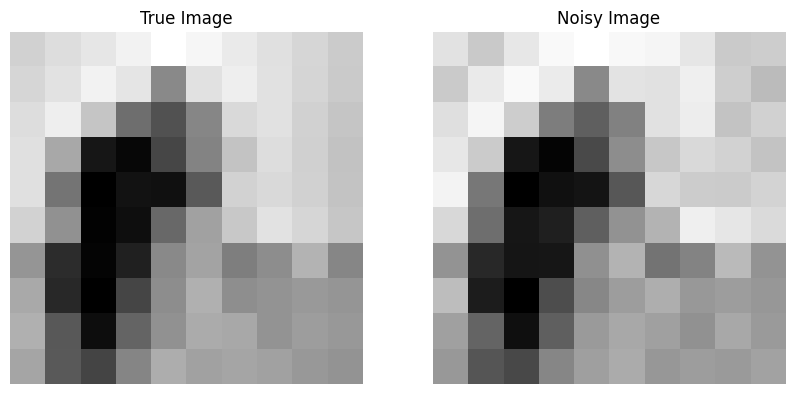

In [6]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(true,cmap='gray')
ax[0].set_title('True Image')
ax[0].axis('off')
ax[1].imshow(noisy,cmap='gray')
ax[1].set_title('Noisy Image')
ax[1].axis('off')

In [7]:
model = TVRegularized(true, noisy, epsilon=1e-3)

In [8]:
res,x_opt,fun_opt = model.solve(max_iter=3000,tol=1e-4,print_level=5)


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.6.2.

Number of nonzeros in equality constraint Jacobian...:     1504
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      281
                     variables with only lower bounds:      101
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      280
Total number of inequality c

In [9]:
u, q, alpha = model.objective_func.parse_vars(x_opt)

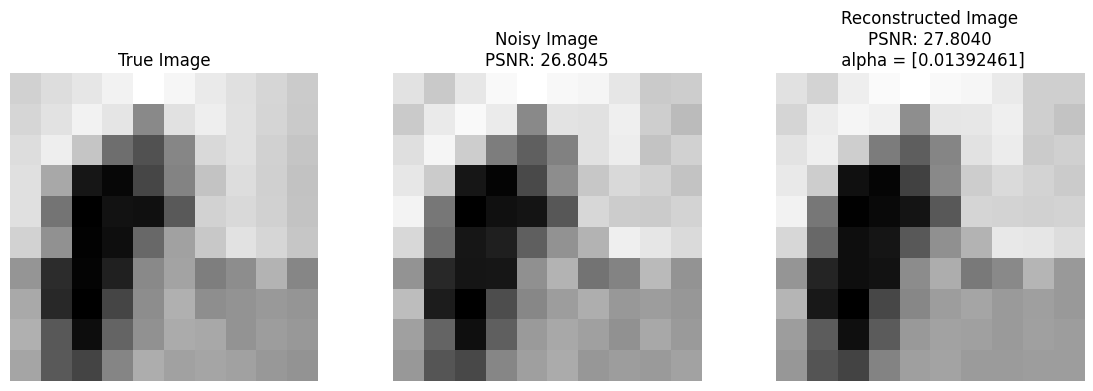

In [10]:
u = u.reshape((scale,scale))
plot_experiment(true,noisy,u,alpha)

In [11]:
m = q.flatten().size
n = m // 2
Ku = model.K @ u.flatten()
V = Ku.reshape(2, -1).T
normKu = np.apply_along_axis(np.linalg.norm, axis=1, arr=V)
Q = q.reshape(2,-1).T
normQ = np.apply_along_axis(np.linalg.norm, axis=1, arr=Q)
r0 = normKu
delta0 = normQ
# theta0 = np.zeros(n)

In [12]:
Kxu = Ku[:n]  # Primeras n componentes
Kyu = Ku[n:]  # Últimas n componentes
qx = q[:n]  # Primeras n componentes
qy = q[n:]  # Últimas n componentes
epsilon = 1e-10

# Condiciones para calcular theta según los casos dados
theta0 = np.zeros(n)  # Inicializamos theta0

# Caso 1: r_i ≠ 0
mask_r_nonzero = r0 > epsilon
theta0[mask_r_nonzero] = np.arccos(Kxu[mask_r_nonzero] / r0[mask_r_nonzero])
theta0[mask_r_nonzero & (Kyu < 0)] *= -1  # Si Ky^i u < 0, negamos theta0

# Caso 2: r_i = 0 y delta_i ≠ 0
mask_r_zero_delta_nonzero = (r0 <= epsilon) & (delta0 > epsilon)
theta0[mask_r_zero_delta_nonzero] = np.arccos(qx[mask_r_zero_delta_nonzero] / delta0[mask_r_zero_delta_nonzero])
theta0[mask_r_zero_delta_nonzero & (qy < 0)] *= -1  # Si qy^i < 0, negamos theta0

# Caso 3: r_i = 0 y delta_i = 0 (theta0 indefinido)
mask_r_zero_delta_zero = (r0 <= epsilon) & (delta0 <= epsilon)
theta0[mask_r_zero_delta_zero] = 0

In [13]:
x0_mpcc = np.concatenate((u.flatten(),q.flatten(),r0,delta0,theta0,alpha))
print(x0_mpcc)

[ 8.65581937e-01  8.15813276e-01  9.14815652e-01  9.56315509e-01
  9.78034126e-01  9.53956885e-01  9.42072219e-01  8.98104802e-01
  8.00999559e-01  8.00962956e-01  8.22489535e-01  9.07624809e-01
  9.40927615e-01  9.20802210e-01  5.59292981e-01  8.83484091e-01
  8.88408292e-01  9.16674679e-01  8.01004840e-01  7.57541520e-01
  8.75060383e-01  9.17454534e-01  7.94732710e-01  4.95087890e-01
  3.85997093e-01  5.26766134e-01  8.67762935e-01  9.06294059e-01
  7.85303945e-01  8.04311105e-01  8.94262695e-01  7.92718052e-01
  9.94213339e-02  5.80886692e-02  2.81329777e-01  5.41454149e-01
  7.92583062e-01  8.41153452e-01  8.17698706e-01  7.84159052e-01
  9.29637079e-01  4.75918752e-01  4.38722286e-02  7.24863375e-02
  1.11228120e-01  3.62304854e-01  8.20066433e-01  8.13962900e-01
  8.07810492e-01  8.17828856e-01  8.27512756e-01  4.21669982e-01
  9.04923877e-02  1.14944747e-01  3.64018609e-01  5.68476800e-01
  6.98090386e-01  8.92106096e-01  8.85392985e-01  8.52847176e-01
  5.87653493e-01  1.71652

In [14]:
mpcc_model = TVDenoisingMPCC(true, noisy, x0=x0_mpcc, epsilon=1e-3)

In [15]:
res_mpcc,x_opt_mpcc,fun_opt_mpcc = mpcc_model.solve(max_iter=300,tol=1e-1,print_level=0,verbose=True,beta=0.5)

Iter   Termination_status            Objective      MPCC_compl               t

0                 0  0.04280470032558853     2.377254552493261                  1.0

1                 0  0.042804697803723896    2.3772465031531014                 0.5

2                 0  0.042804700401765566    1.952664825149564                 0.25

3                 0  0.042804695157281615    1.1833552967125838               0.125

4                 0  0.042961299264650345    0.64712019634752                0.0625

5                 0  0.04416377940287182     0.45590504846365015            0.03125

6                 0  0.04793259713688708     0.29347241609471275           0.015625

7                 0  0.053622858560239704    0.17210256834512377          0.0078125

8                 0  0.06158493551815739     0.11688352129893921         0.00390625

9*                0  0.06867499798570521     0.08313359033973432        0.001953125

In [16]:
u_mpcc, q_mpcc, r_mpcc, delta_mpcc, theta_mpcc, alpha_mpcc = mpcc_model.objective_func.parse_vars(x_opt_mpcc)

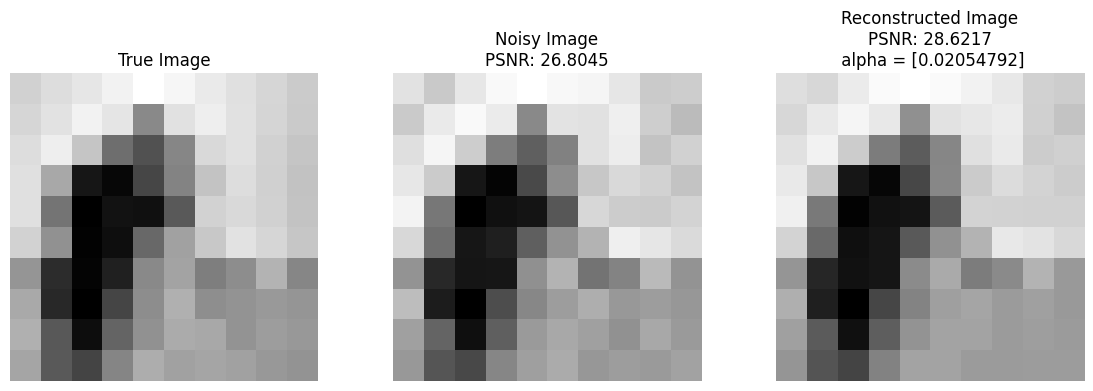

In [17]:
u_mpcc = u_mpcc.reshape((scale,scale))
plot_experiment(true,noisy,u_mpcc,alpha_mpcc)